# Conditional Variational Autoencoder (CVAE)

## Import statements + Device

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from utils import print_np_array_properties, imshow_batch, imshow_with_encoded_labels, get_encoded_attrs, encode_attrs
from tqdm.notebook import tqdm, trange
import warnings
import logging
import time, datetime
str_format = '%Y%m%d%H%M%S'
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Available Device: {device}')

Available Device: cuda


## Dataset

### Download Dataset

In [3]:
## Define preprocessing transformation applied to data
transform = transforms.Compose([
    transforms.ToTensor()
    ])

train_data = datasets.CelebA(
    root='data',
    split='train',
    download=True,
    transform=transform)

valid_data = datasets.CelebA( 
    root='data',
    split='valid',
    download=True,
    transform=transform)

test_data = datasets.CelebA( 
    root='data',
    split='test',
    download=True,
    transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Prep data

torch.Size([64, 3, 218, 178])
['Bags_Under_Eyes', 'Brown_Hair', 'Male', 'Narrow_Eyes', 'No_Beard', 'Wavy_Hair', 'Young']


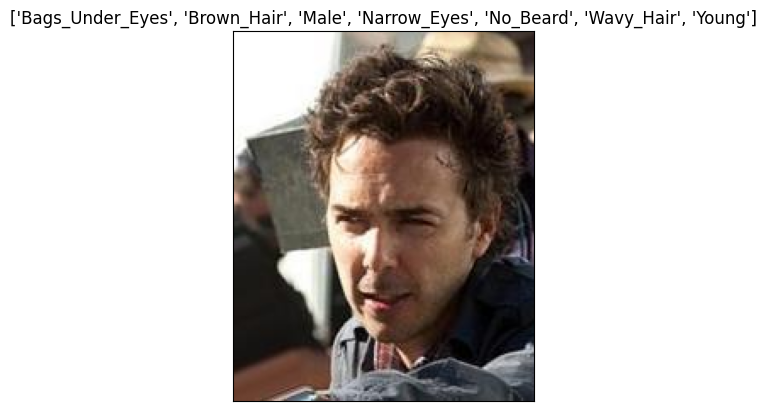

In [4]:
num_workers = 0
# how many samples per batch to load
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

classes = ['5_o_Clock_Shadow','Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes','Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
        'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
        'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)


imshow_with_encoded_labels(1, images, labels, classes)

    
    

## Conditional Variational Autoencoder Architecture

In [5]:
class CVAE(nn.Module):
    def __init__(self, latent_size = 128, num_classes = 40):
        
        super(CVAE, self).__init__()
        
        self.mu=None
        self.logvar=None
        self.latent_size = latent_size
        self.num_classes = num_classes
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3 + self.num_classes, 16, kernel_size=3, padding=1),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            # nn.BatchNorm2d(8),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.mu_fc = nn.Linear(8*54*44, self.latent_size)
        
        self.logvar_fc = nn.Linear(8*54*44, self.latent_size)
        
        self.z_fc = nn.Linear(self.latent_size + self.num_classes, 8*54*44) 
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x, y):
        y = y.reshape(y.shape[0], self.num_classes, 1, 1).repeat(1, 1, 218, 178)
        
        x = torch.cat([x,y], dim=1)
        x = self.encoder(x)
        x = x.view(x.size(0), -1)        
        mu = self.mu_fc(x)
        logvar = self.logvar_fc(x)
        
        return mu, logvar

    def reparam(self, mu, logvar):
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        
        z = mu + eps * std
        return z
    
    
    def decode(self, z, y):
        # y = y.reshape(y.shape[0], self.num_classes, 1, 1).repeat(1, 1, 54, 44)
        # print_np_array_properties(y)
        
        z = torch.cat([z, y.view(y.size(0),-1)], dim=1)
        # print_np_array_properties(z)
        
        z = self.z_fc(z)
        
        z = z.view(z.size(0), 8, 54, 44)
        
        x = self.decoder(z)
        
        return x
            
    def forward(self, x, y):
        
        self.mu, self.logvar = self.encode(x,y)
        z = self.reparam(self.mu, self.logvar)
        x = self.decode(z, y)
        
        return x, self.mu, self.logvar

# def cvae_loss(x_out, x, mu, logvar, beta=0.5):
    
#     BCE = F.binary_cross_entropy(x_out, x, reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
#     return (1-beta)*BCE + beta*KLD

def cvae_loss(x_out, x, mu, logvar, beta=0.5):
    # Reconstruction loss (Mean Squared Error)
    mse_loss = nn.MSELoss(reduction='sum')
    recon_loss = mse_loss(x_out, x)

    # KL-divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (1-beta)*recon_loss + beta*kl_loss, recon_loss, kl_loss


def initialize_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

### Define Model and optimizer

In [6]:
model = CVAE().to(device)
model.apply(initialize_weights)

print(model)

# print_np_array_properties(images)

x, mu, logvar = model(images.to(device), labels.to(device))


print_np_array_properties(x, 'reconstructed x')
print_np_array_properties(mu, 'mu')
print_np_array_properties(logvar, 'logvar')


loss_func = cvae_loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

CVAE(
  (encoder): Sequential(
    (0): Conv2d(43, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mu_fc): Linear(in_features=19008, out_features=128, bias=True)
  (logvar_fc): Linear(in_features=19008, out_features=128, bias=True)
  (z_fc): Linear(in_features=168, out_features=19008, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)
=============== reconstructed x Properties =============

reconstructed x:
 tensor([[[[0.4193, 0.4196, 0.4687,  ..., 0.3615, 0.4992, 0.5116],
          [0.5393, 0.4737, 0.4935,

### Training

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 16867.156892 	Training recon Loss: 82728.170507 	Training kl Loss: 9549.266572 	Validation Loss: 16843.771301 	Validation recpm Loss: 82800.589422 	Validation kl Loss: 9515.235976
Validation loss decreased (inf --> 16843.771301).  Saving model ...


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 16865.970484 	Training recon Loss: 82716.334831 	Training kl Loss: 9549.263406 	Validation Loss: 16842.711990 	Validation recpm Loss: 82786.860318 	Validation kl Loss: 9515.584492
Validation loss decreased (16843.771301 --> 16842.711990).  Saving model ...


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 16866.321213 	Training recon Loss: 82719.661469 	Training kl Loss: 9549.283489 	Validation Loss: 16847.153292 	Validation recpm Loss: 82834.456492 	Validation kl Loss: 9515.230781


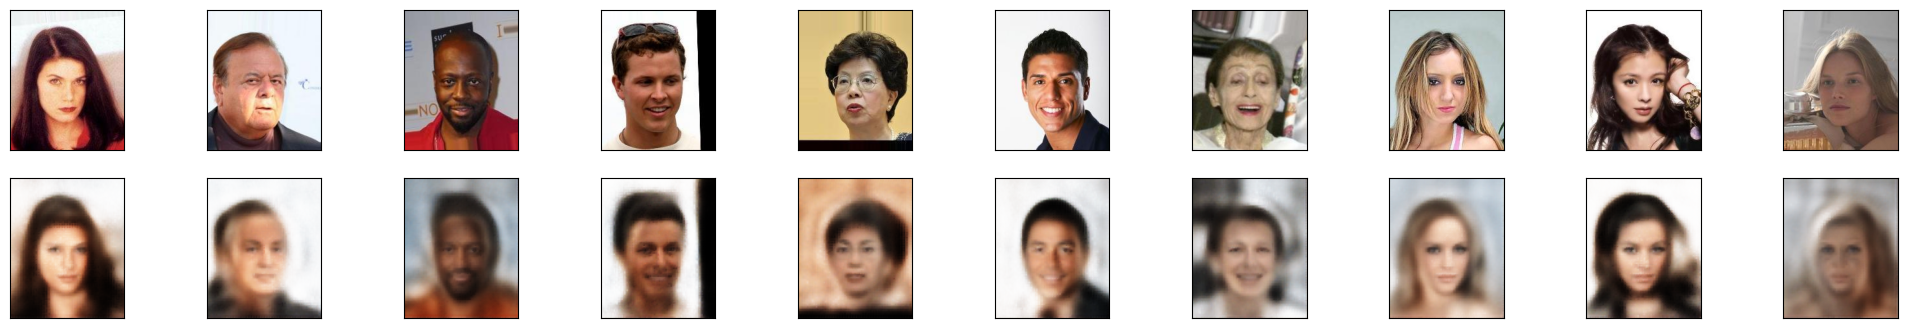

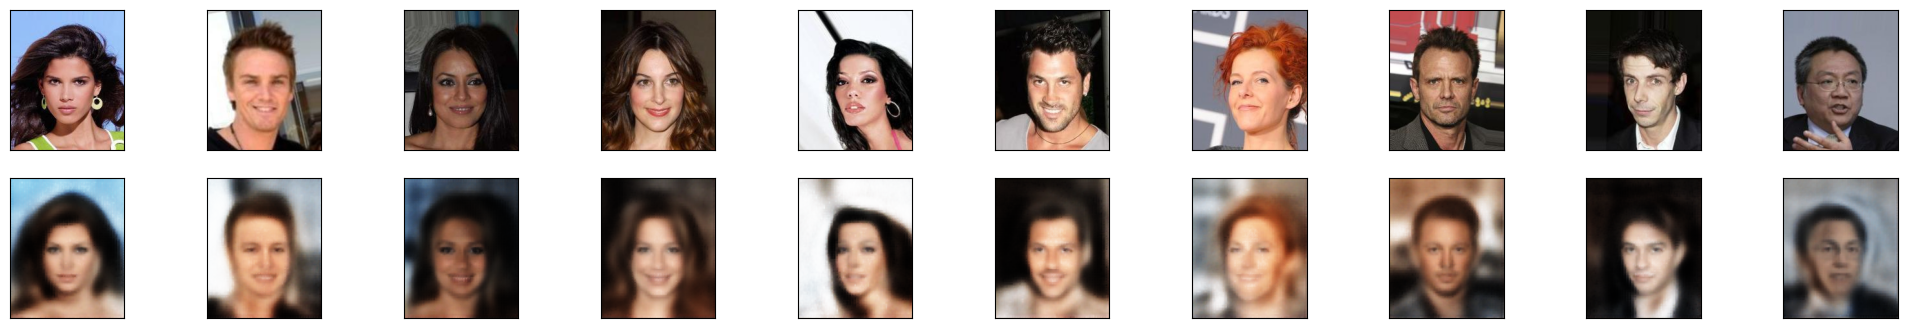

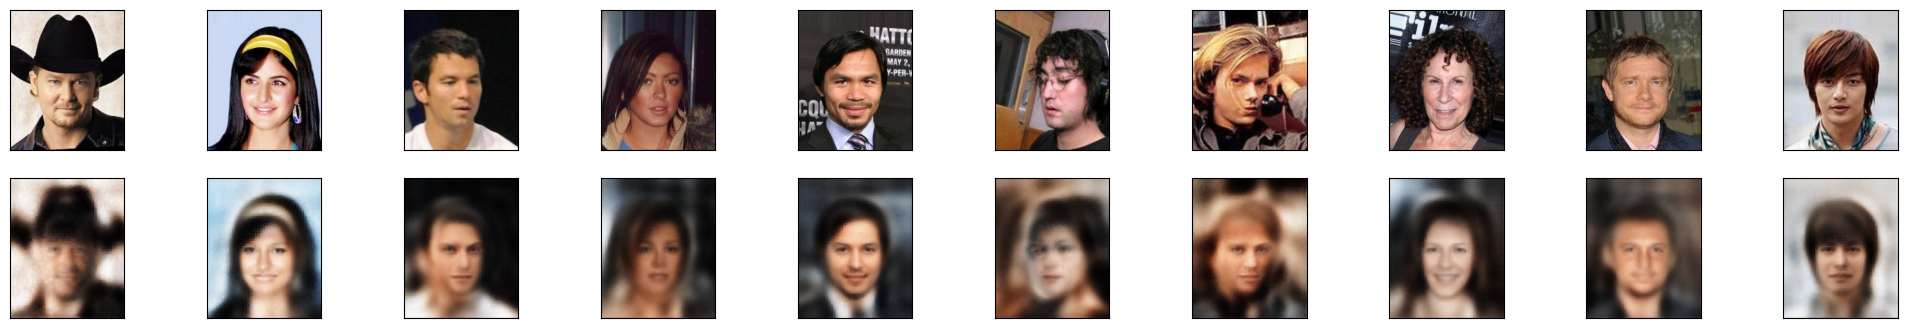

In [22]:
n_epochs=3
ts = datetime.datetime.now().strftime(str_format)
beta = 0.9

valid_loss_min = np.Inf

for epoch in trange(1, n_epochs+1):
    
    train_loss=0.0
    train_recon_loss=0.0
    train_kl_loss=0.0
    
    valid_loss=0.0
    valid_recon_loss=0.0
    valid_kl_loss=0.0
    
    
    ## Training Step
    model.train()
    for images, labels in tqdm(train_loader):
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad() # clar the gradients of all optimized variables
        x_out, mu, logvar = model(images, labels) # Forward pass
        
        loss, recon_loss, kl_loss = loss_func(x_out, images, mu, logvar, beta=beta) # calculate loss of the forward pass
        
        loss.backward() #calculate gradients based on the loss
        
        optimizer.step() # update weights
        
        train_loss += loss.item()*images.size(0)
        train_recon_loss += recon_loss.item()*images.size(0)
        train_kl_loss += kl_loss.item()*images.size(0)
        
    ## Validation Step
    
    model.eval()
    for images, labels in tqdm(valid_loader):
        images, labels = images.to(device), labels.to(device)
        
        x_out, mu, logvar = model(images, labels) # forward pass
        
        loss, recon_loss, kl_loss = loss_func(x_out, images, mu, logvar, beta=beta)
        
        valid_loss += loss.item() * images.size(0)
        valid_recon_loss += recon_loss.item()*images.size(0)
        valid_kl_loss += kl_loss.item()*images.size(0)
    
    # calculate Average loss
    train_loss = train_loss/len(train_loader.dataset)
    train_recon_loss = train_recon_loss/len(train_loader.dataset)
    train_kl_loss = train_kl_loss/len(train_loader.dataset)
    
    valid_loss = valid_loss/len(valid_loader.dataset)
    valid_recon_loss = valid_recon_loss/len(valid_loader.dataset)
    valid_kl_loss = valid_kl_loss/len(valid_loader.dataset)
    
    
    #Print progress statement
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining recon Loss: {:.6f} \tTraining kl Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation recpm Loss: {:.6f} \tValidation kl Loss: {:.6f}'.format(epoch, train_loss,train_recon_loss,train_kl_loss, valid_loss, valid_recon_loss, valid_kl_loss))
    
    #Test after ach epoch
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    view_size = 10 if batch_size >=10 else batch_size
    images = images[:view_size]
    labels = labels[:view_size]

    # get sample outputs
    output, _, _ = model(images.to(device), labels.to(device))
    # prep images for display
    images = images.numpy()

    # output is resized into a batch of iages
    output = output.to('cpu').view(view_size, 3, 218, 178)
    # use detach when it's an output that requires_grad
    output = output.detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.transpose(img, (1,2,0)))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    
    
    #Save model with the lowest validation loss
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), f'./data/CVAE_celebA_{ts}.pt')
        valid_loss_min = valid_loss

### Sample Distribution p(Z|Y) to generate a new face

['Blond_Hair', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Smiling', 'Straight_Hair', 'Wearing_Earrings', 'Wearing_Lipstick', 'Young']
attributes: ['Blond_Hair', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Smiling', 'Straight_Hair', 'Wearing_Earrings', 'Wearing_Lipstick', 'Young']
=============== latent code Properties =============

latent code:
 tensor([[ 1.4720, -0.1605,  0.5515,  ..., -0.1914, -0.4697,  0.7565],
        [ 0.2384,  1.7455,  0.0468,  ...,  0.1945, -1.5649,  0.9456],
        [ 0.5705, -1.1435,  0.1784,  ...,  0.1944,  0.0690,  0.2343],
        ...,
        [-0.7685, -0.8079, -1.2261,  ...,  1.3279,  0.2865, -0.9119],
        [ 0.7161,  1.4145, -0.0338,  ...,  1.0304, -0.5384,  0.7957],
        [ 0.0646, -0.0519, -2.0821,  ...,  0.3923,  0.7159, -0.5527]],
       device='cuda:0')
latent code_dtype: torch.float32
latent code_shape: torch.Size([50, 128])
latent code_size: <built-in method size of Tensor object at 0x7f1319fbc810>



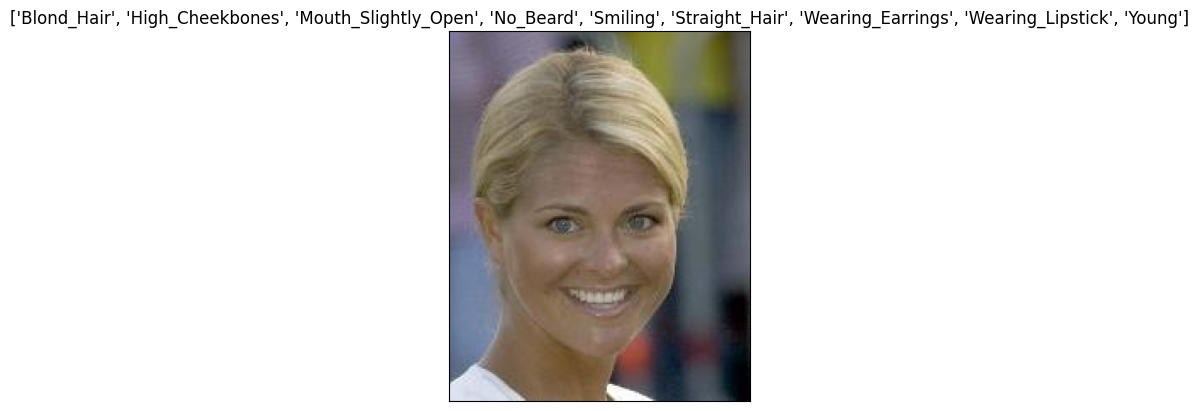

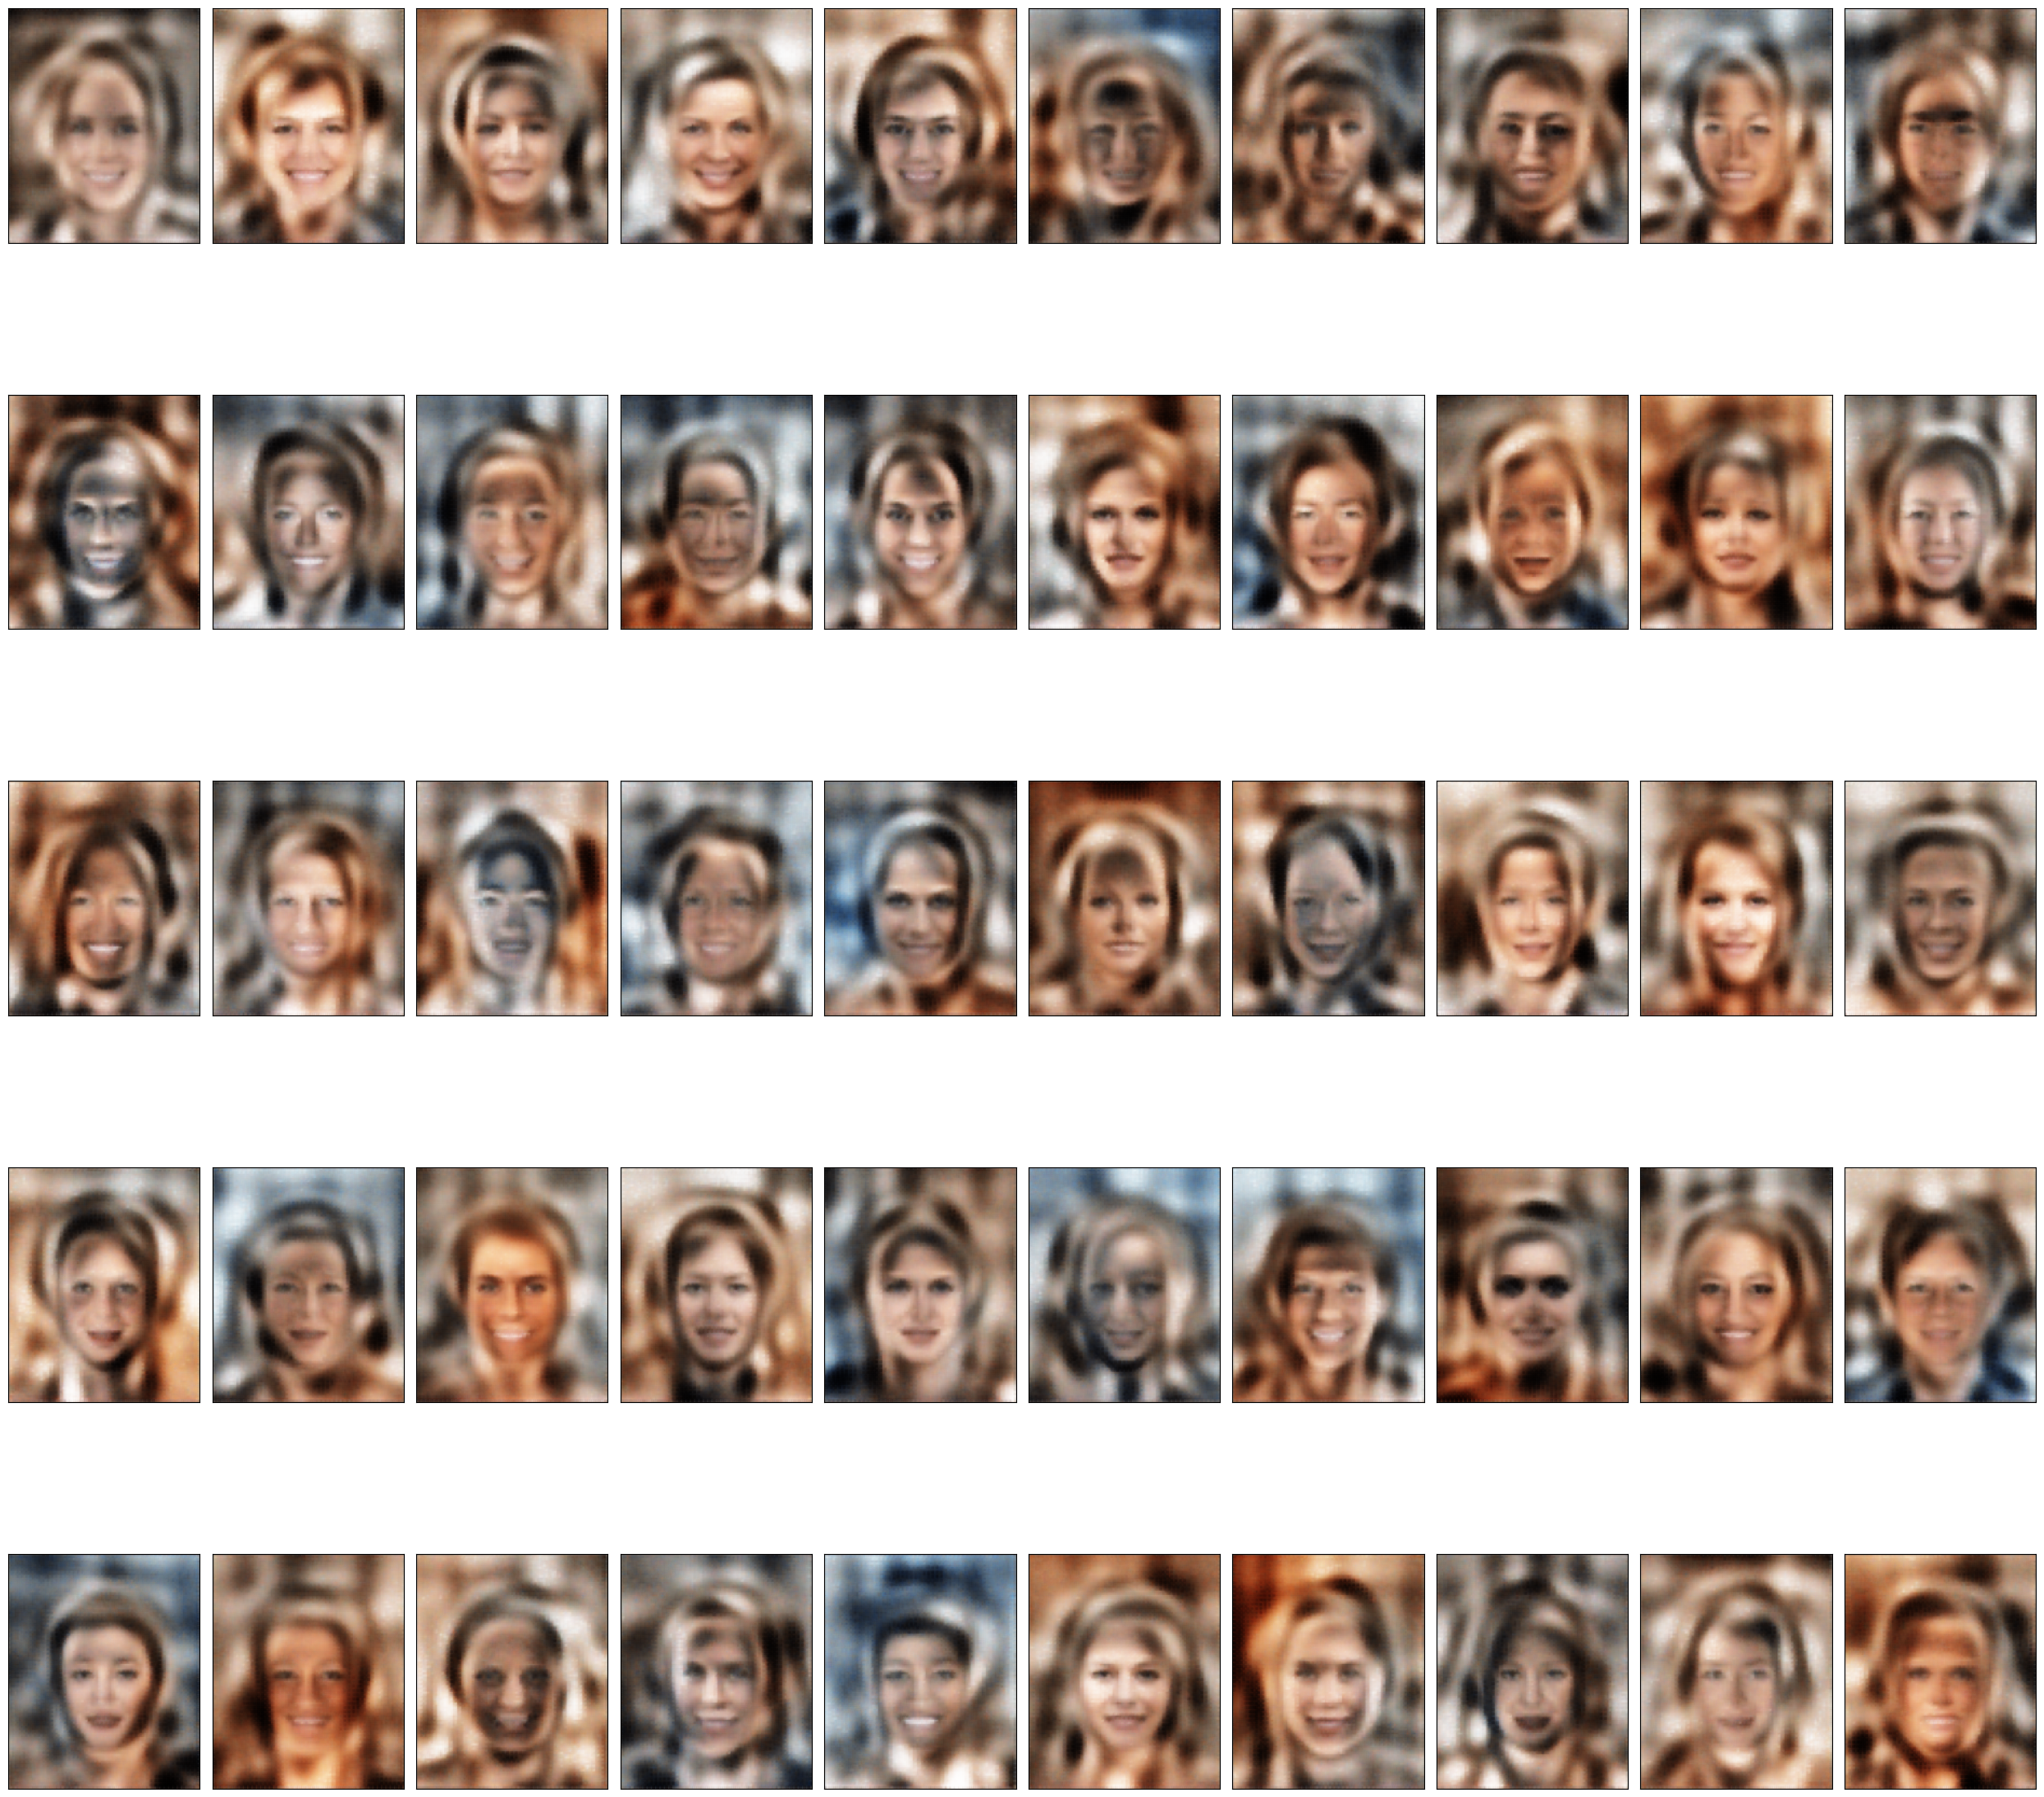

In [7]:
model = CVAE().to(device)
model.load_state_dict(torch.load('./data/CVAE_celebA_20230411232438_MSE_50percent.pt'))
        
group_size = 50
latent_size = model.latent_size 
z = torch.randn(group_size, latent_size).to(device)

dataiter = iter(test_loader)
images, labels = next(dataiter)

label = labels[0]
label_batch = label.reshape(1, model.num_classes).repeat(group_size, 1)

imshow_with_encoded_labels(1, images, labels, classes)
attr = get_encoded_attrs(classes, label)

print(f'attributes: {attr}')

print_np_array_properties(z, name='latent code')

# generate an image from the random latent vector using the decoder
model.eval()
with torch.no_grad():
    output = model.decode(z, label_batch.to(device))
    
output = output.to('cpu')

imshow_batch(group_size, output)


#### This Cell is to print attributes

In [6]:
print(classes)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


###  Sample Distribution p(Z|X) to generate a new face (Custom)

Attributes to reproduce:
['Young', 'Eyeglasses']


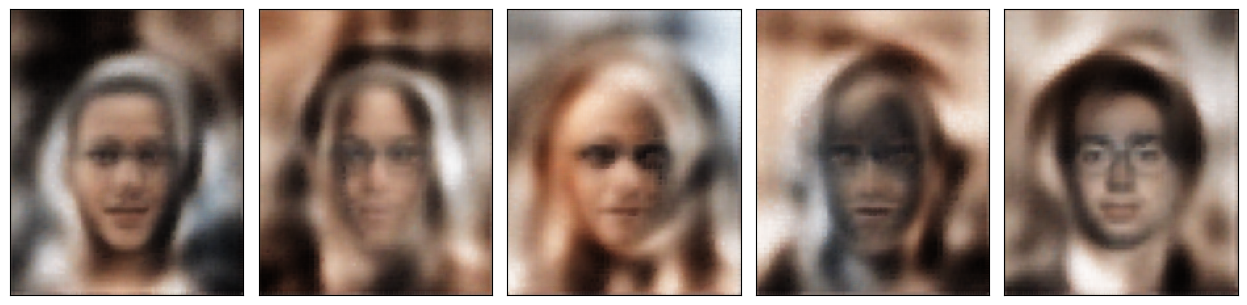

In [24]:
model = CVAE().to(device)
model.load_state_dict(torch.load('./data/CVAE_celebA_20230410194212_90percentkld2.pt'))
# model.load_state_dict(torch.load('./data/CVAE_celebA_20230412010502_MSE_75percent.pt'))
# model.load_state_dict(torch.load('./data/CVAE_celebA_20230411232438_MSE_50percent.pt'))
# model.load_state_dict(torch.load('./data/CVAE_celebA_20230411130854_25percent.pt'))

        
group_size = 5
latent_size = model.latent_size 

z = torch.randn(group_size, latent_size).to(device)

# print_np_array_properties(z, name='latent code')


custom_attrs = ['Young','Eyeglasses']

print(f'Attributes to reproduce:\n{custom_attrs}')


custom_label = torch.tensor(encode_attrs(custom_attrs, classes))

custom_label_batch = custom_label.reshape(1, model.num_classes).repeat(group_size, 1)

# generate an image from the random latent vector using the decoder
model.eval()
with torch.no_grad():
    custom_output = model.decode(z, custom_label_batch.to(device))
    
custom_output = custom_output.to('cpu')

imshow_batch(group_size, custom_output)